# Part 1
Team members:
* Marisol Velapatiño
* Ivo Kusijanovic

# Part 2


*Some parts of this project require a good understanding of the Ultrasonic welding process. Find one or more research papers that explain this process in detail. Then, write a brief description of the Ultrasonic welding process in a single short paragraph, and ensure you correctly reference your data source(s). No AI summary report. Write your own report*

**Ultrasonic welding** has become important in the advent of technologies where lightweight innovations are rising. These can be related but are not limited to the automobile, aviation, and in general transport industries. Composite joints can be made up of different materials, plastic, paper, stainless steel, aluminum to produce high-end quality lightweight parts. Ultrasonic welding is an industry preferred process thanks to its fast welding time to connect components into a solid state. The ultrasonic welding process is a projected type technique of binding : The process needs a vertical force that makes contact with the components through a horn. These components are placed in an anvil and oscillet at high frequencies in the kHz. The energy used and other parameters are dependent on the material being welded. In this project the following will be analyzed: ....

# Part 3
Part 3 Learn to use datasets (30 points):
An ultrasonic welding machine was used to perform a set of experiments. A total of sixty-nine
welding experiments were conducted across seven pressure levels (psi): 10, 20, 30, 40, 50, 60,
and 75. Each condition was repeated ten times. During the welding experiments, two types of
signals—power and force—were collected for each sample. Subsequently, a peel test was
performed to evaluate the welding quality. Based on the results, the samples were categorized
into three classes (as shown in Figure 1): cold, excessive, and good. Dataset: Part3.zip

## Part 3.a

Data preprocessing (5 points): As shown in Figures 2 and 3, the power signals consist of a
main-weld segment and a post-weld segment, while the force signals include a pre-weld
segment, main-weld segment, and post-weld segment.

Based on a physical understanding of the welding process, we know that the main-weld segment is the most informative for quality monitoring. Therefore, our analysis will focus solely on this segment.
Develop an algorithm to automatically extract the main-weld segment for all welds. In your
report, briefly describe the algorithm and demonstrate its effectiveness using one example
for each type of signal. Specifically, plot the raw signal and highlight the boundaries of the
main-weld segment

In [1]:
import pandas as pd
import numpy as np

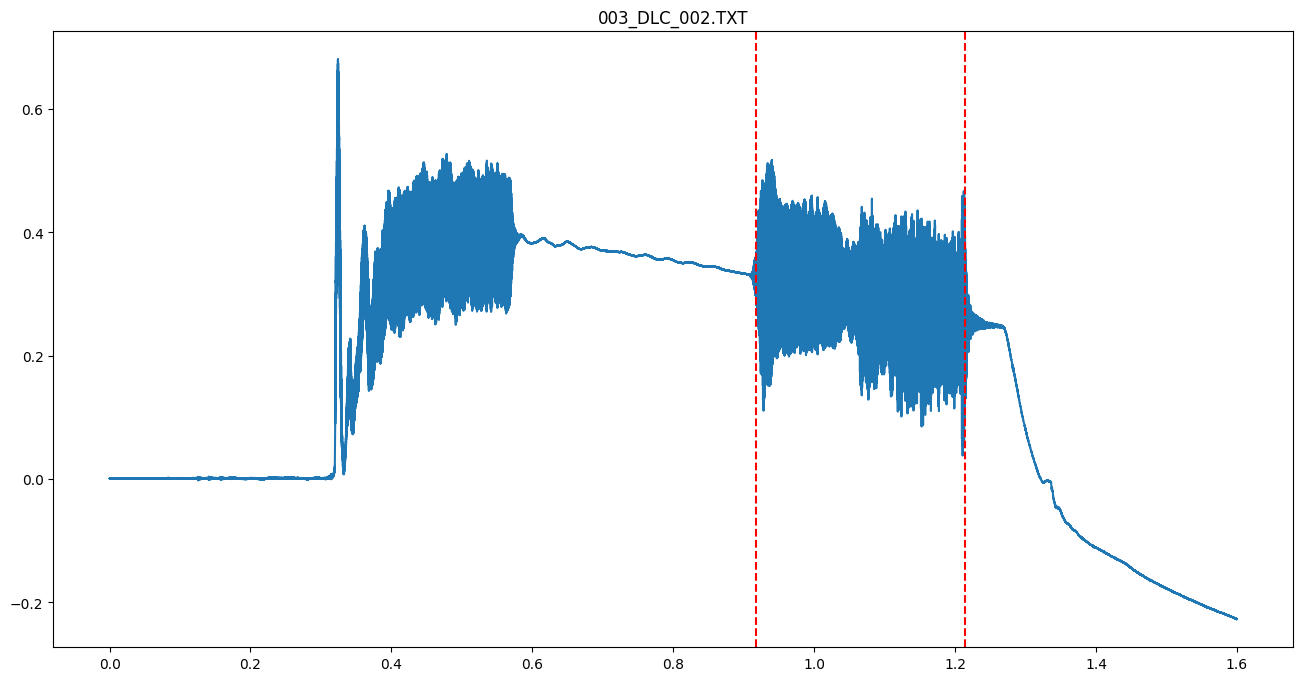

In [2]:
from part3a import extract_force_signals, extract_force_main_weld_segment

force_signal = extract_force_signals()
experiment, time, force = extract_force_main_weld_segment(*force_signal[0], plot=True)

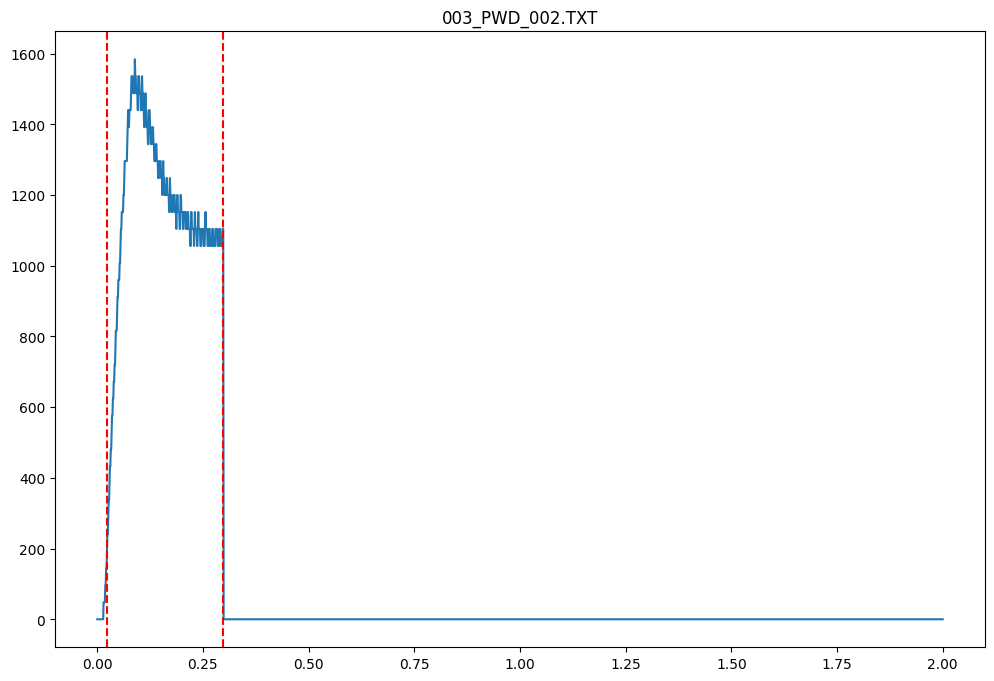

In [3]:
from part3a import extract_power_signals, extract_power_main_weld_segment

power_signals = extract_power_signals()
experiment, time, power = extract_power_main_weld_segment(*power_signals[0], plot=True)

## Part 3.b


Feature generation (8 points): Create features following the steps below and record all
features in a .csv file (part3b.csv).

Each row corresponds to one experiment and each column
corresponds to one parameter/feature. 

The columns should follow this order: experiment
number, quality label, four features from group a, four features from group b, and four
features from group c. This table should be included in your report.


* Process output signals **-Group A-** (2 points): Welding pressure, pre-height, height, and
height change. The first three were recorded by the welder. Height change is the
difference between pre-height and the height.

* Time-domain features from power signals **-Group B-** (3 points): Brainstorm and
  generate four features. In the report, provide the definitions of all features and a
  justification of why these features may be helpful.
  
  We'll be choosing highly discriminative feature that allows us to classify good welds from bad welds:

    * **risePeak** : Shows the maximum power reached during the rise and indicates whether target welding power is achieved. If in the expected range, the risePeak indicates that thermal energy coupled efficiently into the metal which likely produces a good weld. Else if it's too low, the risePeak indicates insufficient heat delivery, poor current conduction ( due to large surface impurity ) and thus a cold weld. If it's too high, the risePeak corresponds to an unstable heat delivery which highly leads to excessive penetration and an excessive weld. 

    * **riseSlope**: This measures how quickly the system reaches operating power. Usually unstable welds have slower rise slopes. A fast rise indicates proper energy coupling: basically how efficiently the electrical power is delivered by the welding machine into heat energy transferred to the joint. A slow or noisy rise means the connection struggles to form and the power is lost to poor contact or instability.

    * **riseDuration**: Indicates the time needed to reach the peak and is complementary to the riseSlope. As explained earlier, a longer rise duration generally correlate with poor contact and energy coupling which can cause a bad weld.

    * **dipDepth**: This is the change in height between the risePeak and the ramp/stable power signal. A deep dip after the risePeak likely means that the controller had to pull back to correct and overshoot, indicating a poor heat transfer and bad weld. Conforming welds usually have shallow dip, indicating efficient heat transfer.

* Frequency-domain features from force signals **-Group C-** (3 points): Generate the
following features: 1st peak frequency and magnitude, 2nd peak frequency and
magnitude.

In [14]:
from part3b import extract_features_group_b

name = "part3b.csv"
col_names = ["experiment number", "quality label", "Welding Pressure", "pre-height", "height", "height change", "risePeak", "riseSlope", "riseDuration", "dipDepth", "1peakFreq" , "1peakMag", "2peakFreq", "2peakMag"]
file  = './data/part3/WeldClassification.xls'

df = pd.read_excel(file, skiprows=6)

zero_data = np.zeros(shape=(len(df['Run No.']),len(col_names)))

data_frame = pd.DataFrame(zero_data, columns=col_names)

# ## Group A

data_frame[col_names[0]] = df['Run No.']
data_frame[col_names[1]] = df['Class Label']
data_frame[col_names[2]] = df['Pressure [psi]']
data_frame[col_names[3]] = df['PreHeight [mm]']
data_frame[col_names[4]] = df['Height [mm]']
data_frame[col_names[5]] = abs(df['Height [mm]'] - df['PreHeight [mm]'])

##Group B

rise_peaks = []
rise_slopes = []
rise_durations = []
dip_depths = []

for power_signal in power_signals:
    
    experiment, time, power = extract_power_main_weld_segment(*power_signal)
    rise_peak, rise_slope, rise_duration, dip_depth = extract_features_group_b(time, power)

    rise_peaks.append(rise_peak)
    rise_slopes.append(rise_slope)
    rise_durations.append(rise_duration)
    dip_depths.append(dip_depth)

data_frame[col_names[6]] = np.array(rise_peaks)
data_frame[col_names[7]] = np.array(rise_slopes)
data_frame[col_names[8]] = np.array(rise_durations)
data_frame[col_names[9]] = np.array(dip_depths)

##Group C
